<a href="https://colab.research.google.com/github/Snafkin547/Quantum-ML-classification/blob/main/Wine_Classiciation_3Var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package and Data Ingestion

In [1]:
from google.colab import drive
import os
import pandas as pd

#Google Drive mounting to Google Colab
drive.mount('/content/gdrive', force_remount=True)
#Change the working directory
%cd /content/gdrive/MyDrive/QML/Wine-Classification
#Check if the directory was properly changed
%pwd

#Loading from previously saved train-test split
x_train= pd.read_pickle('./x_train.npy')
x_test= pd.read_pickle('./x_test.npy')
y_train= pd.read_pickle('./y_train.npy')
y_test= pd.read_pickle('./y_test.npy')

Mounted at /content/gdrive
/content/gdrive/MyDrive/QML/Wine-Classification


# Train the model and Predict

In [2]:
from sklearn.ensemble import RandomForestClassifier as rfm
from sklearn.metrics import accuracy_score

clf=rfm(max_depth=2, random_state=0)
clf.fit(x_train,y_train)
y_hat=clf.predict(x_test)
print("Model accuracy is {}%".format(clf.score(x_test, y_test)*100))
benchmark=clf.score(x_test, y_test)*100

Model accuracy is 72.5%


# Identify The biggest contributing Features

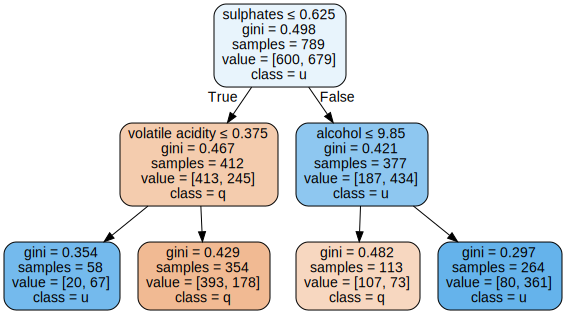

In [3]:
import sklearn
import graphviz 
from sklearn.tree import export_graphviz
dot_data = sklearn.tree.export_graphviz(clf.estimators_[0], out_file=None, 
                     feature_names=x_train.columns,  
                      class_names="quality", 
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

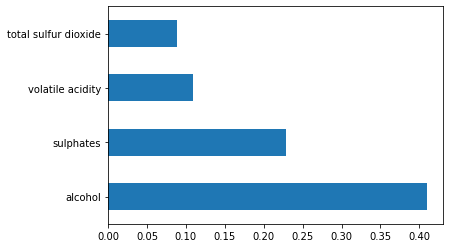

In [4]:
import numpy as np
import pandas as pd
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(4).plot(kind='barh')

# Store 2, 3, and 4 biggest Contributors

In [5]:
two_var=feat_importances.nlargest(4).index[0:2]
three_var=feat_importances.nlargest(4).index[0:3]
four_var=feat_importances.nlargest(4).index[0:4]

# Preparation for Quantum Circuit

In [ ]:
!pip install qiskit
!pip install pylatexenc ipywidgets qutip

In [7]:
train=pd.concat([x_train, y_train], axis=1)
train['int_quality']=list(map(lambda item: 1 if item=='good' else 0, train['quality']))
test=pd.concat([x_test, y_test], axis=1)
test['int_quality']=list(map(lambda item: 1 if item=='good' else 0, test['quality']))
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,int_quality
803,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,good,1
124,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,bad,0
350,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,good,1
682,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,bad,0
1326,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,good,1


In [8]:
var_name=['al_hi', 'sul_hi','vol_ac_hi', 'sul_dio_hi']
for obj, name in zip(four_var, var_name):
  train[name]=list(map(lambda x: 1 if x>train[obj].mean() else 0, train[obj]))
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,int_quality,al_hi,sul_hi,vol_ac_hi,sul_dio_hi
493,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6,good,1,1,1,1,1
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9,good,1,1,0,0,1
342,10.9,0.390,0.47,1.8,0.118,6.0,14.0,0.99820,3.30,0.75,9.8,good,1,0,1,0,0
834,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4,bad,0,0,0,1,0
705,8.4,1.035,0.15,6.0,0.073,11.0,54.0,0.99900,3.37,0.49,9.9,bad,0,0,0,1,1


In [9]:
var_name=['al_hi', 'sul_hi','vol_ac_hi', 'sul_dio_hi']
for obj, name in zip(four_var, var_name):
  test[name]=list(map(lambda x: 1 if x>test[obj].mean() else 0, test[obj]))
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,int_quality,al_hi,sul_hi,vol_ac_hi,sul_dio_hi
803,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,good,1,0,1,1,1
124,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,bad,0,0,0,0,1
350,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,good,1,0,1,1,0
682,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,bad,0,0,0,0,1
1326,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,good,1,1,0,0,0


In [10]:
#Probability of being high alcohol rate 
cnt_al_hi=len(train[train['al_hi']==1])
cnt_al_lo=len(train[train['al_hi']!=1])
prob_al_hi=cnt_al_hi/len(train)

#Probability of being high sulphate rate 
cnt_sul_hi=len(train[train['sul_hi']==1])
cnt_sul_lo=len(train[train['sul_hi']!=1])
prob_sul_hi=cnt_sul_hi/len(train)

#Probability of being high volatile acidity rate 
cnt_volac_hi=len(train[train['vol_ac_hi']==1])
cnt_volac_lo=len(train[train['vol_ac_hi']!=1])
prob_volac_hi=cnt_volac_hi/len(train)

#Probability of being good quality wine
cnt_qual_hi=len(train[train['quality']=="good"])
cnt_qual_lo=len(train[train['quality']!="good"])
prob_good=cnt_qual_hi/len(train)


In [11]:
#High Qual, High Al, High sul, High Vol Acidity
HA=train[train['al_hi']==1]
HA_HS=HA[HA['sul_hi']==1]
HA_HS_HVA=HA_HS[HA_HS['vol_ac_hi']==1]

HQ_HA_HS_HVA=HA_HS_HVA[HA_HS_HVA['quality']=="good"]
p_HQ_HA_HS_HVA=len(HQ_HA_HS_HVA)/len(HA_HS_HVA)

LQ_HA_HS_HVA=HA_HS_HVA[HA_HS_HVA['quality']=="bad"]
p_LQ_HA_HS_HVA=len(LQ_HA_HS_HVA)/len(HA_HS_HVA)

#High Qual, High Al, Low sul, High Vol Acidity
HA=train[train['al_hi']==1]
HA_LS=HA[HA['sul_hi']!=1]
HA_LS_HVA=HA_LS[HA_LS['vol_ac_hi']==1]

HQ_HA_LS_HVA=HA_LS_HVA[HA_LS_HVA['quality']=="good"]
p_HQ_HA_LS_HVA=len(HQ_HA_LS_HVA)/len(HA_LS_HVA)

LQ_HA_LS_HVA=HA_LS_HVA[HA_LS_HVA['quality']=="bad"]
p_LQ_HA_LS_HVA=len(LQ_HA_LS_HVA)/len(HA_LS_HVA)


#High Qual, Low Al, High sul, High Vol Acidity
LA=train[train['al_hi']!=1]
LA_HS=LA[LA['sul_hi']==1]
LA_HS_HVA=LA_HS[LA_HS['vol_ac_hi']==1]

HQ_LA_HS_HVA=LA_HS_HVA[LA_HS_HVA['quality']=="good"]
p_HQ_LA_HS_HVA=len(HQ_LA_HS_HVA)/len(LA_HS_HVA)
LQ_LA_HS_HVA=LA_HS_HVA[LA_HS_HVA['quality']=="bad"]
p_LQ_LA_HS_HVA=len(LQ_LA_HS_HVA)/len(LA_HS_HVA)


#High Qual, Low Al, Low sul, High Vol Acidity
LA=train[train['al_hi']!=1]
LA_LS=LA[LA['sul_hi']!=1]
LA_LS_HVA=LA_LS[LA_LS['vol_ac_hi']==1]

HQ_LA_LS_HVA=LA_LS_HVA[LA_LS_HVA['quality']=="good"]
p_HQ_LA_LS_HVA=len(HQ_LA_LS_HVA)/len(LA_LS_HVA)
LQ_LA_LS_HVA=LA_LS_HVA[LA_LS_HVA['quality']=="bad"]
p_LQ_LA_LS_HVA=len(LQ_LA_LS_HVA)/len(LA_LS_HVA)


#High Qual, High Al, High sul, Low Vol Acidity
HA=train[train['al_hi']==1]
HA_HS=HA[HA['sul_hi']==1]
HA_HS_LVA=HA_HS[HA_HS['vol_ac_hi']!=1]

HQ_HA_HS_LVA=HA_HS_LVA[HA_HS_LVA['quality']=="good"]
p_HQ_HA_HS_LVA=len(HQ_HA_HS_LVA)/len(HA_HS_LVA)
LQ_HA_HS_LVA=HA_HS_LVA[HA_HS_LVA['quality']=="bad"]
p_LQ_HA_HS_LVA=len(LQ_HA_HS_LVA)/len(HA_HS_LVA)

#High Qual, High Al, Low sul, Low Vol Acidity
HA=train[train['al_hi']==1]
HA_LS=HA[HA['sul_hi']!=1]
HA_LS_LVA=HA_LS[HA_LS['vol_ac_hi']!=1]

HQ_HA_LS_LVA=HA_LS_LVA[HA_LS_LVA['quality']=="good"]
p_HQ_HA_LS_LVA=len(HQ_HA_LS_LVA)/len(HA_LS_LVA)
LQ_HA_LS_LVA=HA_LS_LVA[HA_LS_LVA['quality']=="bad"]
p_LQ_HA_LS_LVA=len(LQ_HA_LS_LVA)/len(HA_LS_LVA)

#High Qual, Low Al, High sul, Low Vol Acidity
LA=train[train['al_hi']!=1]
LA_HS=LA[LA['sul_hi']==1]
LA_HS_LVA=LA_HS[LA_HS['vol_ac_hi']!=1]

HQ_LA_HS_LVA=LA_HS_LVA[LA_HS_LVA['quality']=="good"]
p_HQ_LA_HS_LVA=len(HQ_LA_HS_LVA)/len(LA_HS_LVA)

LQ_LA_HS_LVA=LA_HS_LVA[LA_HS_LVA['quality']=="bad"]
p_LQ_LA_HS_LVA=len(LQ_LA_HS_LVA)/len(LA_HS_LVA)

#High Qual, Low Al, Low sul, Low Vol Acidity
LA=train[train['al_hi']!=1]
LA_LS=LA[LA['sul_hi']!=1]
LA_LS_LVA=LA_LS[LA_LS['vol_ac_hi']!=1]

HQ_LA_LS_LVA=LA_LS_LVA[LA_LS_LVA['quality']=="good"]
p_HQ_LA_LS_LVA=len(HQ_LA_LS_LVA)/len(LA_LS_LVA)

LQ_LA_LS_LVA=LA_LS_LVA[LA_LS_LVA['quality']=="bad"]
p_LQ_LA_LS_LVA=len(LQ_LA_LS_LVA)/len(LA_LS_LVA)

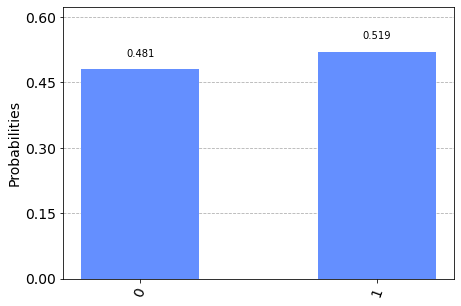

In [12]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, result
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi, sqrt, sin, cos, asin


def prob_to_angle(prob):
  return 2*asin(sqrt(prob))

def ccry(qc, theta, control1, control2, controlled):
  qc.cry(theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(-theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(theta/2, control1, controlled)

def cccry(qc, theta, control1, control2, control3, controlled):
  qc.cry(theta/2, control3, controlled)
  qc.ccx(control1, control2, control3)
  qc.cry(-theta/2, control3, controlled)
  qc.ccx(control1, control2, control3)
  ccry(qc, theta/2, control1, control2, controlled)

QPOS_AL=0
QPOS_SUL=1
QPOS_VA=2
QPOS_NORM=3
QUBITS=4

qr=QuantumRegister(QUBITS)
cr=ClassicalRegister(1)
qc=QuantumCircuit(qr,cr)

# Apply prob of high alcohol 
qc.ry(prob_to_angle(prob_al_hi),QPOS_AL)

# Apply prob of high sulohide 
qc.ry(prob_to_angle(prob_sul_hi),QPOS_SUL)

# Apply prob of high volatile Acidity
qc.ry(prob_to_angle(prob_volac_hi),QPOS_VA)


# |1100> for cond prob of High Qual, Low Al & Low Sul  & High Vol Ac
qc.x(QPOS_AL)
qc.x(QPOS_SUL)
cccry(qc, prob_to_angle(p_HQ_LA_LS_HVA), QPOS_AL, QPOS_SUL, QPOS_VA, QPOS_NORM)
qc.x(QPOS_SUL)
qc.x(QPOS_AL)

# |1110> for cond prob of High Qual, Low Al & High Sul & High Vol Ac
qc.x(QPOS_AL)
cccry(qc, prob_to_angle(p_HQ_LA_HS_HVA), QPOS_AL, QPOS_SUL, QPOS_VA, QPOS_NORM)
qc.x(QPOS_AL)

# |1101> for cond prob of High Qual, High Al & Low Sul & High Vol Ac
qc.x(QPOS_SUL)
cccry(qc, prob_to_angle(p_HQ_HA_LS_HVA), QPOS_AL, QPOS_SUL, QPOS_VA, QPOS_NORM)
qc.x(QPOS_SUL)


# |1111> for cond prob of High Qual, High Al & High Sul & High Vol Ac
cccry(qc, prob_to_angle(p_HQ_HA_HS_HVA), QPOS_AL, QPOS_SUL, QPOS_VA, QPOS_NORM)

# |1000> for cond prob of High Qual, Low Al & Low Sul  & Low Vol Ac
qc.x(QPOS_AL)
qc.x(QPOS_SUL)
qc.x(QPOS_VA)
cccry(qc, prob_to_angle(p_HQ_LA_LS_LVA), QPOS_AL, QPOS_SUL, QPOS_VA, QPOS_NORM)
qc.x(QPOS_VA)
qc.x(QPOS_SUL)
qc.x(QPOS_AL)


# |1010> for cond prob of High Qual, Low Al & High Sul & Low Vol Ac
qc.x(QPOS_AL)
qc.x(QPOS_VA)
cccry(qc, prob_to_angle(p_HQ_LA_HS_LVA), QPOS_AL, QPOS_SUL, QPOS_VA, QPOS_NORM)
qc.x(QPOS_VA)
qc.x(QPOS_AL)

# |1001> for cond prob of High Qual, High Al & Low Sul & Low Vol Ac
qc.x(QPOS_SUL)
qc.x(QPOS_VA)
cccry(qc, prob_to_angle(p_HQ_HA_LS_LVA), QPOS_AL, QPOS_SUL, QPOS_VA, QPOS_NORM)
qc.x(QPOS_VA)
qc.x(QPOS_SUL)

# |1011> for cond prob of High Qual, High Al & High Sul & Low Vol Ac
qc.x(QPOS_VA)
cccry(qc, prob_to_angle(p_HQ_HA_HS_LVA), QPOS_AL, QPOS_SUL, QPOS_VA, QPOS_NORM)
qc.x(QPOS_VA)


qc.measure(qr[QPOS_NORM], cr[0])
results=execute(qc,Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
plot_histogram(results)


In [13]:
def as_pqc(cnt_quantum, with_qc, cnt_classical=1, shots=1, hist=False, measure=False):
# Prepare the circuit with qubits and a classical bit to hold the measurement
  qr = QuantumRegister(cnt_quantum)
  cr = ClassicalRegister(cnt_classical)
  qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

  with_qc(qc, qr=qr, cr=cr)

  results = execute(qc,
  Aer.get_backend('statevector_simulator') if measure is False else Aer.get_backend('qasm_simulator'),
  shots=shots).result().get_counts()

  return plot_histogram(results, figsize=(12,4)) if hist else results

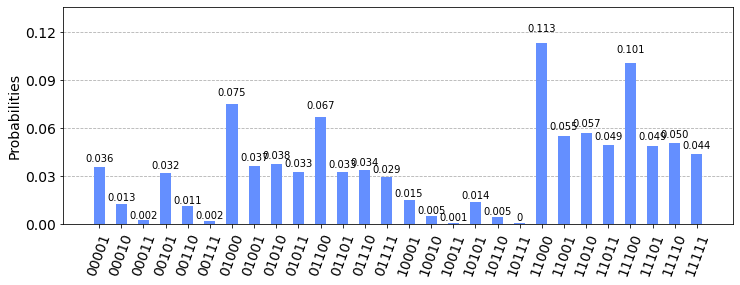

In [14]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, result
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi, sqrt, sin, cos, asin


QPOS_AL=0
QPOS_SUL=1
QPOS_VA=2
QPOS_NORM=3
QPOS_QUAL=4
QUBITS=5

qr=QuantumRegister(QUBITS)
cr=ClassicalRegister(1)
qc=QuantumCircuit(qr,cr)

def prob_to_angle(prob):
  return 2*asin(sqrt(prob))

def ccry(qc, theta, control1, control2, controlled):
  qc.cry(theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(-theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(theta/2, control1, controlled)

def cccry(qc, theta, control1, control2, control3, controlled):
  qc.cry(theta/2, control3, controlled)
  qc.ccx(control1, control2, control3)
  qc.cry(-theta/2, control3, controlled)
  qc.ccx(control1, control2, control3)
  ccry(qc, theta/2, control1, control2, controlled)

def apply_al_sul_va(qc):
  # Apply prob of high alcohol 
  qc.ry(prob_to_angle(prob_al_hi),QPOS_AL)

  # Apply prob of high sul 
  qc.ry(prob_to_angle(prob_sul_hi),QPOS_SUL)

  # Apply prob of high vol ac 
  qc.ry(prob_to_angle(prob_volac_hi),QPOS_VA)

def apply_norm(qc, norm_params):
  # |1100> for cond prob of Low Al & Low Sul, High Vol Ac & High Qual
  qc.x(QPOS_AL)
  qc.x(QPOS_SUL)
  ccry(qc, prob_to_angle(norm_params['p_llhh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_SUL)
  qc.x(QPOS_AL)

  # |1110> for cond prob of Low Al & High Sul, High Vol Ac & High Qual
  qc.x(QPOS_AL)
  ccry(qc, prob_to_angle(norm_params['p_lhhh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_AL)

  # |1101> for cond prob of High Al & Low Sul, High Vol Ac & High Qual
  qc.x(QPOS_SUL)
  ccry(qc, prob_to_angle(norm_params['p_hlhh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_SUL)

  # |1111> for cond prob of High Al & High Sul, High Vol Ac & High Qual
  ccry(qc, prob_to_angle(norm_params['p_hhhh']), QPOS_AL, QPOS_SUL, QPOS_NORM)

  # |1000> for cond prob of Low Al & Low Sul, Low Vol Ac & High Qual
  qc.x(QPOS_AL)
  qc.x(QPOS_SUL)
  qc.x(QPOS_VA)
  ccry(qc, prob_to_angle(norm_params['p_lllh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_VA)
  qc.x(QPOS_SUL)
  qc.x(QPOS_AL)

  # |1010> for cond prob of Low Al & High Sul, Low Vol Ac & High Qual
  qc.x(QPOS_AL)
  qc.x(QPOS_VA)
  ccry(qc, prob_to_angle(norm_params['p_lhlh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_VA)
  qc.x(QPOS_AL)

  # |1001> for cond prob of High Al & Low Sul, Low Vol Ac & High Qual
  qc.x(QPOS_SUL)
  qc.x(QPOS_VA)
  ccry(qc, prob_to_angle(norm_params['p_hllh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_VA)
  qc.x(QPOS_SUL)

  # |1011> for cond prob of High Al & High Sul, Low Vol Ac & High Qual
  qc.x(QPOS_VA)
  ccry(qc, prob_to_angle(norm_params['p_hhlh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_VA)

def apply_qual(qc, qual_params):
  qc.x(QPOS_NORM)
  qc.cry(prob_to_angle(qual_params['p_qual_u']), QPOS_NORM, QPOS_QUAL)
  qc.x(QPOS_NORM)

  qc.cry(prob_to_angle(qual_params['p_qual_f']), QPOS_NORM, QPOS_QUAL)

def qbn_wine(norm_params, qual_params, hist=True, measure=False, shots=1):
  def circuit(qc, qr=None, cr=None):
    apply_al_sul_va(qc)
    apply_norm(qc, norm_params)
    apply_qual(qc, qual_params)
  return as_pqc(QUBITS, circuit, hist=hist, measure=measure, shots=shots)

norm_params={
    'p_llhh': 0.5,
    'p_lhhh': 0.3,
    'p_hlhh': 0.2,
    'p_hhhh': 0.4,
    'p_lllh': 0.5,
    'p_lhlh': 0.3,
    'p_hllh': 0.2,
    'p_hhlh': 0.4
}

qual_params={
    'p_qual_f':0.6,
    'p_qual_u':0.3
}

qbn_wine(norm_params, qual_params, hist=True, measure=False, shots=1)

In [15]:
def calculate_norm_params(train):

  #High Qual, High Al, High sul, High Vol Acidity
  HA=train[train['al_hi']==1]
  HA_HS=HA[HA['sul_hi']==1]
  HA_HS_HVA=HA_HS[HA_HS['vol_ac_hi']==1]

  #High Qual, High Al, Low sul, High Vol Acidity
  HA=train[train['al_hi']==1]
  HA_LS=HA[HA['sul_hi']!=1]
  HA_LS_HVA=HA_LS[HA_LS['vol_ac_hi']==1]

  #High Qual, Low Al, High sul, High Vol Acidity
  LA=train[train['al_hi']!=1]
  LA_HS=LA[LA['sul_hi']==1]
  LA_HS_HVA=LA_HS[LA_HS['vol_ac_hi']==1]

  #High Qual, Low Al, Low sul, High Vol Acidity
  LA=train[train['al_hi']!=1]
  LA_LS=LA[LA['sul_hi']!=1]
  LA_LS_HVA=LA_LS[LA_LS['vol_ac_hi']==1]

  #High Qual, High Al, High sul, Low Vol Acidity
  HA=train[train['al_hi']==1]
  HA_HS=HA[HA['sul_hi']==1]
  HA_HS_LVA=HA_HS[HA_HS['vol_ac_hi']!=1]

  #High Qual, High Al, Low sul, Low Vol Acidity
  HA=train[train['al_hi']==1]
  HA_LS=HA[HA['sul_hi']!=1]
  HA_LS_LVA=HA_LS[HA_LS['vol_ac_hi']!=1]

  #High Qual, Low Al, High sul, Low Vol Acidity
  LA=train[train['al_hi']!=1]
  LA_HS=LA[LA['sul_hi']==1]
  LA_HS_LVA=LA_HS[LA_HS['vol_ac_hi']!=1]

  #High Qual, Low Al, Low sul, Low Vol Acidity
  LA=train[train['al_hi']!=1]
  LA_LS=LA[LA['sul_hi']!=1]
  LA_LS_LVA=LA_LS[LA_LS['vol_ac_hi']!=1]
  norm_params={
      'p_llhh': LA_LS_HVA.Norm.sum()/len(LA_LS_HVA),
      'p_lhhh': LA_HS_HVA.Norm.sum()/len(LA_HS_HVA),
      'p_hlhh': HA_LS_HVA.Norm.sum()/len(HA_LS_HVA),
      'p_hhhh': HA_HS_HVA.Norm.sum()/len(HA_HS_HVA),
      'p_lllh': LA_LS_LVA.Norm.sum()/len(LA_LS_LVA),
      'p_lhlh': LA_HS_LVA.Norm.sum()/len(LA_HS_LVA),
      'p_hllh': HA_LS_LVA.Norm.sum()/len(HA_LS_LVA),
      'p_hhlh': HA_HS_LVA.Norm.sum()/len(HA_HS_LVA)
  }

  return norm_params

In [16]:
def calculate_qual_params(data):
  hi_quality=data[data['quality']=='good']
  
  def weight_qual(norm):
    return lambda qual: qual if norm else 1-qual

  def calc_prob(norm):
    return sum(list(map(weight_qual(norm), list(hi_quality['Norm']))))/sum(list(map(weight_qual(norm), list(data['Norm']))))

  qual_params={
    'p_qual_f':calc_prob(True),
    'p_qual_u':calc_prob(False)
  }

  return qual_params

In [19]:
def prepare_data(data, params):
  data['Norm']=list(map(
      lambda item: params['p_norm_{}{}{}{}'.format(
          'h' if item[0]==1 else 'l',
          'h' if item[1]==1 else 'l',
          'h' if item[1]==1 else 'l',
          'h' if item[2]=='good' else 'l'
      )],
      list(zip(data['al_hi'], data['sul_hi'], data['vol_ac_hi'], data['quality']))
      ))
  return data 

In [20]:
def filter_states(states, position, value):
  return list(filter(lambda item: item[0][QUBITS-1-position]==str(value), states))

def sum_states(states):
  return sum(map(lambda item: item[1], states))

In [21]:
from math import log

def log_likelihood_wine(data, results):
  states=results.items()

  def calc_prob(norm_val, hi_al, hi_sul, hi_va, hi_qual):
    return sum_states(
        filter_states(
          filter_states(
            filter_states(
                filter_states(
                    filter_states(states, QPOS_AL, hi_al),
                      QPOS_SUL, hi_sul),
                      QPOS_QUAL, hi_qual),
                      QPOS_VA, hi_va),
                      QPOS_NORM, norm_val))
  
  probs={
    'p_fhhhh': calc_prob('1', '1','1','1','1'),
    'p_fhlhh': calc_prob('1', '1','0','1','1'),
    'p_flhhh': calc_prob('1', '0','1','1','1'),
    'p_fllhh': calc_prob('1', '0','0','1','1'),
    'p_fhhhl': calc_prob('1', '1','1','1','0'),
    'p_fhlhl': calc_prob('1', '1','0','1','0'),
    'p_flhhl': calc_prob('1', '0','1','1','0'),
    'p_fllhl': calc_prob('1', '0','0','1','0'),
    'p_uhhhh': calc_prob('0', '1','1','1','1'),
    'p_uhlhh': calc_prob('0', '1','0','1','1'),
    'p_ulhhh': calc_prob('0', '0','1','1','1'),
    'p_ullhh': calc_prob('0', '0','0','1','1'),
    'p_uhhhl': calc_prob('0', '1','1','1','0'),
    'p_uhlhl': calc_prob('0', '1','0','1','0'),
    'p_ulhhl': calc_prob('0', '0','1','1','0'),
    'p_ullhl': calc_prob('0', '0','0','1','0'),
    'p_fhhlh': calc_prob('1', '1','1','0','1'),
    'p_fhllh': calc_prob('1', '1','0','0','1'),
    'p_flhlh': calc_prob('1', '0','1','0','1'),
    'p_flllh': calc_prob('1', '0','0','0','1'),
    'p_fhhll': calc_prob('1', '1','1','0','0'),
    'p_fhlll': calc_prob('1', '1','0','0','0'),
    'p_flhll': calc_prob('1', '0','1','0','0'),
    'p_fllll': calc_prob('1', '0','0','0','0'),
    'p_uhhlh': calc_prob('0', '1','1','0','1'),
    'p_uhllh': calc_prob('0', '1','0','0','1'),
    'p_ulhlh': calc_prob('0', '0','1','0','1'),
    'p_ulllh': calc_prob('0', '0','0','0','1'),
    'p_uhhll': calc_prob('0', '1','1','0','0'),
    'p_uhlll': calc_prob('0', '1','0','0','0'),
    'p_ulhll': calc_prob('0', '0','1','0','0'),
    'p_ullll': calc_prob('0', '0','0','0','0')
  }
  return round(sum(map(
      lambda item: log(probs['p_{}{}{}{}{}'.format(
          'u',
          'h' if item[1]==1 else 'l',
          'h' if item[2]==1 else 'l',
          'h' if item[3]==1 else 'l',
          'h' if item[4]==1 else 'l'
          )] + probs['p_{}{}{}{}{}'.format(
          'f',
          'h' if item[1]==1 else 'l',
          'h' if item[2]==1 else 'l',
          'h' if item[3]==1 else 'l',
          'h' if item[4]==1 else 'l'
          )]
      ),
      list(zip(data['Norm'], data['al_hi'], data['sul_hi'], data['vol_ac_hi'], data['quality']))
  )),3)


In [22]:
def to_params(results):
  states=results.items()

  def calc_norm(hi_al, hi_sul, hi_va, hi_qual):
    pop=filter_states(filter_states(filter_states(filter_states(states, QPOS_AL, hi_al),QPOS_SUL, hi_sul),QPOS_VA, hi_va),QPOS_QUAL, hi_qual)
    p_norm=sum(map(lambda item: item[1], filter_states(pop, QPOS_NORM, '1')))
    p_total=sum(map(lambda item: item[1], pop))
    return p_norm/p_total
  
  return{
    'p_norm_hhhh': calc_norm('1','1','1', '1'),
    'p_norm_hlhh': calc_norm('1','0','1', '1'),
    'p_norm_lhhh': calc_norm('0','1','1', '1'),
    'p_norm_llhh': calc_norm('0','0','1', '1'),
    'p_norm_hhhl': calc_norm('1','1','1', '0'),
    'p_norm_hlhl': calc_norm('1','0','1', '0'),
    'p_norm_lhhl': calc_norm('0','1','1', '0'),
    'p_norm_llhl': calc_norm('0','0','0', '0'),
    'p_norm_hhlh': calc_norm('1','1','0', '1'),
    'p_norm_hllh': calc_norm('1','0','0', '1'),
    'p_norm_lhlh': calc_norm('0','1','0', '1'),
    'p_norm_lllh': calc_norm('0','0','0', '1'),
    'p_norm_hhll': calc_norm('1','1','0', '0'),
    'p_norm_hlll': calc_norm('1','0','0', '0'),
    'p_norm_lhll': calc_norm('0','1','0', '0'),
    'p_norm_llll': calc_norm('0','0','0', '0')
    }


In [23]:
def train_qbn_wine(prepared_data, params, iterations, print=False):
  if iterations>0:

    new_params=train_qbn_wine(prepared_data, params, iterations-1)
    prepared_data=prepare_data(prepared_data, new_params)
    results=qbn_wine(calculate_norm_params(prepared_data),
                     calculate_qual_params(prepared_data), hist=False)
    if print:
      print('The log−likelihood after {} iteration(s) is {}'.format(iterations, log_likelihood_wine(prepared_data, results)))
    return to_params(results)
  
  return params

arbitrary_params={
    'p_norm_hhhh': p_HQ_HA_HS_HVA,
    'p_norm_hlhh': p_HQ_HA_LS_HVA,
    'p_norm_lhhh': p_HQ_LA_HS_HVA,
    'p_norm_llhh': p_HQ_LA_LS_HVA,
    'p_norm_hhhl': p_LQ_HA_HS_HVA,
    'p_norm_hlhl': p_LQ_HA_LS_HVA,
    'p_norm_lhhl': p_LQ_LA_HS_HVA,
    'p_norm_llhl': p_LQ_LA_LS_HVA,
    'p_norm_hhlh': p_HQ_HA_HS_LVA,
    'p_norm_hllh': p_HQ_HA_LS_LVA,
    'p_norm_lhlh': p_HQ_LA_HS_LVA,
    'p_norm_lllh': p_HQ_LA_LS_LVA,
    'p_norm_hhll': p_LQ_HA_HS_LVA,
    'p_norm_hlll': p_LQ_HA_LS_LVA,
    'p_norm_lhll': p_LQ_LA_HS_LVA,
    'p_norm_llll': p_LQ_LA_LS_LVA
    }

In [24]:
def pre_process(prepared_data):
  return (prepared_data['al_hi']==1, prepared_data['sul_hi']==1, prepared_data['vol_ac_hi']==1)

In [25]:
def apply_known(qc, al_hi, sul_hi, va_hi):
  if al_hi:
    qc.x(QPOS_AL)
  if sul_hi:
    qc.x(QPOS_SUL)
  if va_hi:
    qc.x(QPOS_VA)

In [26]:
def get_trained_qbn(data, params):
  prepared_data=prepare_data(data, params)
  norm_params=calculate_norm_params(data)
  qual_params=calculate_qual_params(data)

  def trained_qbn_wine(d):
    (al_hi, sul_hi, va_hi) = d

    def circuit(qc, qr, cr):
      apply_known(qc, al_hi, sul_hi, va_hi)
      apply_norm(qc, norm_params)
      apply_qual(qc, qual_params)
      qc.measure(qr[QPOS_QUAL], cr[0])
    
    return as_pqc(QUBITS, circuit, hist=False, measure=True, shots=100)
  
  return trained_qbn_wine

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def specificity(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[0][1]) if (matrix[0][0]+matrix[0][1] > 0) else 0

def npv(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[1][0]) if (matrix[0][0]+matrix[1][0] > 0) else 0

def accuracy(matrix):
   return (matrix[0][0]+matrix[1][1])/(matrix[0][0]+matrix[0][1]+matrix[1][0]+matrix[1][1]) if (matrix[0][0]+matrix[0][1]+matrix[1][0]+matrix[1][1] > 0) else 0

def classifier_report(name, run, classify, input, labels):
    cr_predictions = run(classify, input)
    cr_cm = confusion_matrix(labels, cr_predictions)
    cr_precision = precision_score(labels, cr_predictions)
    cr_recall = recall_score(labels, cr_predictions)
    cr_specificity = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_level = 0.25*(cr_precision + cr_recall + cr_specificity + cr_npv)
    accuracy_s=accuracy(cr_cm)

    print('The precision score of the {} classifier is {:.2f}'
        .format(name, cr_precision))
    print('The recall score of the {} classifier is {:.2f}'
        .format(name, cr_recall))
    print('The specificity score of the {} classifier is {:.2f}'
        .format(name, cr_specificity))
    print('The npv score of the {} classifier is {:.2f}'
        .format(name, cr_npv))
    print('The information level is: {:.2f}'
        .format(cr_level))
    print('The accuracy of the model is: {:.2f}'
        .format(accuracy_s))
    print('')

    return accuracy_s

def run(f_classify, data):
    return [f_classify(data.iloc[i]) for i in range(0,len(data))]

def post_process(counts):
  p_good=counts['1'] if '1' in counts.keys() else 0
  p_bad=counts['0'] if '0' in counts.keys() else 0
  return 1 if p_good>p_bad else 0

# Predict

---Test data 1 Iterations---
The precision score of the QBN classifier is 0.54
The recall score of the QBN classifier is 0.89
The specificity score of the QBN classifier is 0.02
The npv score of the QBN classifier is 0.13
The information level is: 0.39
The accuracy of the model is: 0.51

---Training data 1 Iteration---
The precision score of the QBN classifier is 0.51
The recall score of the QBN classifier is 0.88
The specificity score of the QBN classifier is 0.05
The npv score of the QBN classifier is 0.27
The information level is: 0.43
The accuracy of the model is: 0.49

---Test data 10 Iterations---
The precision score of the QBN classifier is 0.61
The recall score of the QBN classifier is 0.35
The specificity score of the QBN classifier is 0.71
The npv score of the QBN classifier is 0.46
The information level is: 0.53
The accuracy of the model is: 0.51

---Training data 10 Iteration---
The precision score of the QBN classifier is 0.66
The recall score of the QBN classifier is 0.42

([<matplotlib.axis.XTick at 0x7f9be1c85110>,
 <a list of 5 Text major ticklabel objects>)

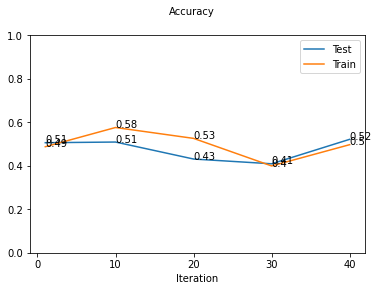

In [33]:
def predict(train, test, arbitrary_params, iter):
    trained_params=train_qbn_wine(train, arbitrary_params,iter)

    trained_qbn=get_trained_qbn(train, trained_params)

    return classifier_report("QBN",
                    run,
                    lambda d : post_process(trained_qbn(pre_process(d))),
                    test,
                    test['int_quality']
                    )

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i],round(y[i],2))
        
iterations=[1,10,20,30,40]
results_test=[]
results_train=[]

arbitrary_params={
    'p_norm_hhhh': p_HQ_HA_HS_HVA,
    'p_norm_hlhh': p_HQ_HA_LS_HVA,
    'p_norm_lhhh': p_HQ_LA_HS_HVA,
    'p_norm_llhh': p_HQ_LA_LS_HVA,
    'p_norm_hhhl': p_LQ_HA_HS_HVA,
    'p_norm_hlhl': p_LQ_HA_LS_HVA,
    'p_norm_lhhl': p_LQ_LA_HS_HVA,
    'p_norm_llhl': p_LQ_LA_LS_HVA,
    'p_norm_hhlh': p_HQ_HA_HS_LVA,
    'p_norm_hllh': p_HQ_HA_LS_LVA,
    'p_norm_lhlh': p_HQ_LA_HS_LVA,
    'p_norm_lllh': p_HQ_LA_LS_LVA,
    'p_norm_hhll': p_LQ_HA_HS_LVA,
    'p_norm_hlll': p_LQ_HA_LS_LVA,
    'p_norm_lhll': p_LQ_LA_HS_LVA,
    'p_norm_llll': p_LQ_LA_LS_LVA
    }

for i in iterations:
   print("---Test data {} Iterations---".format(i))
   results_test.append(predict(train, test, arbitrary_params, i))
   print("---Training data {} Iteration---".format(i))
   results_train.append(predict(train, train, arbitrary_params, i))

plt.plot(iterations, results_test, label="Test")
addlabels(iterations, results_test)
plt.plot(iterations, results_train, label="Train")
addlabels(iterations, results_train)
plt.xlabel("Iteration")
plt.ylim(0,1)
plt.legend()
plt.suptitle('Accuracy',fontsize=10)
plt.xticks(np.arange(0, 50,10))